# Logistic Regression Example
## Bank dataset to determine if a customer would buy a CD
The data is related with direct marketing campaigns of a Portuguese banking institution.  The marketing campaigns were based on phone calls.  A number of features such as age, kind of job, marital status, education level, credit default, existence of housing loan, etc. were considered.  The classification goal is to predict if the client will subscribe (yes/no) a term deposit.

More information regarding the data set is at https://archive.ics.uci.edu/ml/datasets/bank+marketing#.

<font color='blue'>__ The objective is to demonstrate the use of logistic regression and to tune hyperparameters enet_lamba and enet_alpha. __</font>

## Attribute Information:

### Input variables:
#### Bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

#### Related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### Other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Social and economic context attributes:
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')


# Initialization
Set up the imports, logging, and loading of the data sets.

In [1]:
from hana_ml import dataframe
from hana_ml.algorithms.pal import linear_model
from hana_ml.algorithms.pal import clustering
from hana_ml.algorithms.pal import trees
import numpy as np
import matplotlib.pyplot as plt
import logging
from IPython.core.display import Image, display

## Load data
The data is loaded into 3 tables, one for the test set, another for the training set, and finally the validation set:
<li>DBM2_RTEST_TBL</li>
<li>DBM2_RTRAINING_TBL</li>
<li>DBM2_RVALIDATION_TBL</li>

To do that, a connection is created and passed to the loader.

There is a config file, config/e2edata.ini that controls the connection parameters and whether or not to reload the data from scratch.  In case the data is already loaded, there would be no need to load the data.  A sample section is below.  If the config parameter, reload_data is true then the tables for test, training, and validation are (re-)created and data inserted into them.

Although this ini file has other sections, please do not modify them. Only the [hana] section should be modified.

#########################<br>
[hana]<br>
url=host.sjc.sap.corp<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
#########################<br>

In [2]:
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_bank_data(connection_context)

# Create Data Frames
Create the data frames for the full, test, training, and validation sets.

Let us also do some data exploration.

## Define Datasets - Training, validation, and test sets
Data frames are used keep references to data so computation on large data sets in HANA can happen in HANA.  Trying to bring the entire data set into the client will likely result in out of memory exceptions.

The original/full dataset is split into training, test and validation sets.  In the example below, they reside in different tables.

In [3]:
full_set = connection_context.table(full_tbl)
training_set = connection_context.table(training_tbl)
validation_set = connection_context.table(validation_tbl)
test_set = connection_context.table(test_tbl)

## Simple Exploration
Let us look at the number of rows in the data set

In [4]:
print('Number of rows in full set: {}'.format(full_set.count()))
print('Number of rows in training set: {}'.format(training_set.count()))
print('Number of rows in validation set: {}'.format(validation_set.count()))
print('Number of rows in test set: {}'.format(test_set.count()))

Number of rows in full set: 41188
Number of rows in training set: 16895
Number of rows in validation set: 12096
Number of rows in test set: 12197


Let's look at the columns

In [5]:
print(full_set.columns)

['ID', 'AGE', 'JOB', 'MARITAL', 'EDUCATION', 'DBM_DEFAULT', 'HOUSING', 'LOAN', 'CONTACT', 'DBM_MONTH', 'DAY_OF_WEEK', 'DURATION', 'CAMPAIGN', 'PDAYS', 'PREVIOUS', 'POUTCOME', 'EMP_VAR_RATE', 'CONS_PRICE_IDX', 'CONS_CONF_IDX', 'EURIBOR3M', 'NREMPLOYED', 'LABEL']


Let's look at the data types

In [6]:
full_set.dtypes()

[('ID', 'INT', 10),
 ('AGE', 'INT', 10),
 ('JOB', 'VARCHAR', 256),
 ('MARITAL', 'VARCHAR', 100),
 ('EDUCATION', 'VARCHAR', 256),
 ('DBM_DEFAULT', 'VARCHAR', 100),
 ('HOUSING', 'VARCHAR', 100),
 ('LOAN', 'VARCHAR', 100),
 ('CONTACT', 'VARCHAR', 100),
 ('DBM_MONTH', 'VARCHAR', 100),
 ('DAY_OF_WEEK', 'VARCHAR', 100),
 ('DURATION', 'DOUBLE', 15),
 ('CAMPAIGN', 'INT', 10),
 ('PDAYS', 'INT', 10),
 ('PREVIOUS', 'INT', 10),
 ('POUTCOME', 'VARCHAR', 100),
 ('EMP_VAR_RATE', 'DOUBLE', 15),
 ('CONS_PRICE_IDX', 'DOUBLE', 15),
 ('CONS_CONF_IDX', 'DOUBLE', 15),
 ('EURIBOR3M', 'DOUBLE', 15),
 ('NREMPLOYED', 'INT', 10),
 ('LABEL', 'VARCHAR', 10)]

In [7]:
features = ['AGE','JOB','MARITAL','EDUCATION','DBM_DEFAULT', 'HOUSING','LOAN','CONTACT','DBM_MONTH','DAY_OF_WEEK','DURATION','CAMPAIGN','PDAYS','PREVIOUS','POUTCOME','EMP_VAR_RATE','CONS_PRICE_IDX','CONS_CONF_IDX','EURIBOR3M','NREMPLOYED']
label = "LABEL"

### Let us look at some rows

In [8]:
training_set.head(5).collect()

,ID,AGE,JOB,MARITAL,EDUCATION,DBM_DEFAULT,HOUSING,LOAN,CONTACT,DBM_MONTH,...,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,EURIBOR3M,NREMPLOYED,LABEL
0,28115,41,admin.,married,basic.6y,no,no,no,cellular,apr,...,2,999,1,failure,-1.8,93.075,-47.1,1.479,5099,yes
1,28120,38,entrepreneur,married,professional.course,no,yes,yes,cellular,apr,...,2,999,1,failure,-1.8,93.075,-47.1,1.466,5099,no
2,28122,42,management,married,unknown,no,yes,no,cellular,apr,...,2,999,1,failure,-1.8,93.075,-47.1,1.466,5099,no
3,28124,50,management,divorced,university.degree,unknown,no,no,telephone,apr,...,6,999,1,failure,-1.8,93.075,-47.1,1.466,5099,yes
4,28131,38,admin.,single,high.school,no,yes,no,cellular,apr,...,2,999,1,failure,-1.8,93.075,-47.1,1.466,5099,no


In [9]:
training_set.filter("\"LABEL\"='yes'").head(5).collect()

,ID,AGE,JOB,MARITAL,EDUCATION,DBM_DEFAULT,HOUSING,LOAN,CONTACT,DBM_MONTH,...,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,EURIBOR3M,NREMPLOYED,LABEL
0,28115,41,admin.,married,basic.6y,no,no,no,cellular,apr,...,2,999,1,failure,-1.8,93.075,-47.1,1.479,5099,yes
1,28124,50,management,divorced,university.degree,unknown,no,no,telephone,apr,...,6,999,1,failure,-1.8,93.075,-47.1,1.466,5099,yes
2,28133,53,blue-collar,married,basic.4y,unknown,yes,no,cellular,apr,...,2,999,1,failure,-1.8,93.075,-47.1,1.466,5099,yes
3,28170,37,blue-collar,married,basic.6y,no,yes,no,cellular,apr,...,2,999,1,failure,-1.8,93.075,-47.1,1.466,5099,yes
4,28294,48,blue-collar,married,basic.9y,no,yes,no,cellular,apr,...,3,999,2,failure,-1.8,93.075,-47.1,1.445,5099,yes


# Create Model and Tune Hyperparameters
Try different hyperparameters and see what parameter is best.
The results are stored in a list called res which can then be used to visualize the results.

_The variable "quick" is to run the tests for only a few values to avoid running the code below for a long time._


In [10]:
quick = True
enet_lambdas = np.linspace(0.01,0.02, endpoint=False, num=1) if quick else np.append(np.linspace(0.01,0.02, endpoint=False, num=4), np.linspace(0.02,0.02, num=5))
enet_alphas = np.linspace(0, 1, num=4) if quick else np.linspace(0, 1, num=40)
res = []
for enet_alpha in enet_alphas:
    for enet_lambda in enet_lambdas:
        lr = linear_model.LogisticRegression(connection_context, solver='Cyclical', tol=0.000001, max_iter=10000, 
                                               stat_inf=True,pmml_export='multi-row', lamb=enet_lambda, alpha=enet_alpha,
                                               class_map0='no', class_map1='yes')
        lr.fit(training_set, features=features, label=label)
        accuracy_val = lr.score(validation_set, 'ID', features, label)
        res.append((enet_alpha, enet_lambda, accuracy_val, lr.coef_))

## Graph the results
Plot the accuracy on the validation set against the hyperparameters.

This is only done if all the combinations are tried.

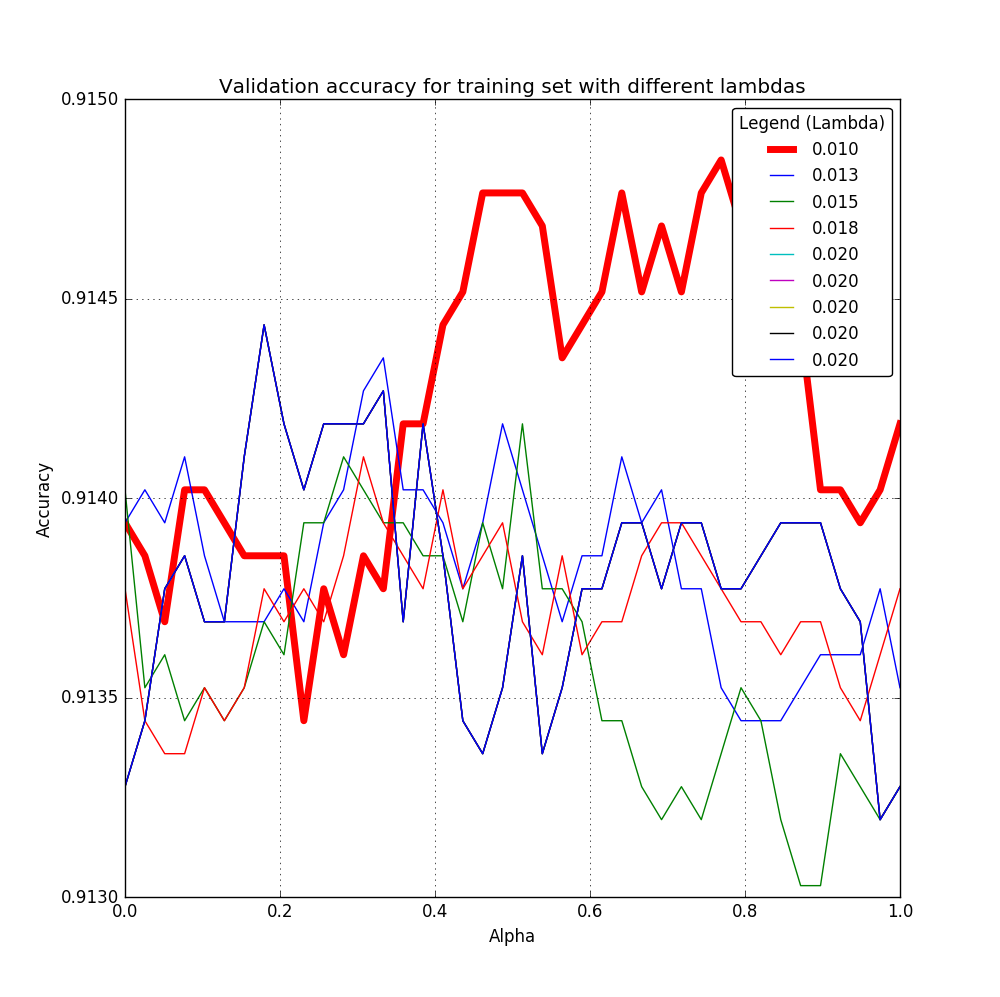

Best accuracy: 0.9148
Value of alpha for maximum accuracy: 0.769
Value of lambda for maximum accuracy: 0.010


In [11]:
%matplotlib inline
if not quick:
    arry = np.asarray(res)
    fig = plt.figure(figsize=(10,10))
    plt.title("Validation accuracy for training set with different lambdas")
    ax = fig.add_subplot(111)
    most_accurate_lambda = arry[np.argmax(arry[:,2]),1]
    best_accuracy_arg = np.argmax(arry[:,2])
    for lamda in enet_lambdas:
        if lamda == most_accurate_lambda:
            ax.plot(arry[arry[:,1]==lamda][:,0], arry[arry[:,1]==lamda][:,2], label="%.3f" % round(lamda,3), linewidth=5, c='r')
        else:
            ax.plot(arry[arry[:,1]==lamda][:,0], arry[arry[:,1]==lamda][:,2], label="%.3f" % round(lamda,3))
    plt.legend(loc=1, title="Legend (Lambda)", fancybox=True, fontsize=12)
    ax.set_xlabel('Alpha', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.show()
    print("Best accuracy: %.4f" % (arry[best_accuracy_arg][2]))
    print("Value of alpha for maximum accuracy: %.3f\nValue of lambda for maximum accuracy: %.3f\n" % (arry[best_accuracy_arg][0], arry[best_accuracy_arg][1]))
else:
    display(Image('images/bank-data-hyperparameter-tuning.png', width=800, unconfined=True))
    print("Best accuracy: 0.9148")
    print("Value of alpha for maximum accuracy: 0.769")
    print("Value of lambda for maximum accuracy: 0.010")

# Predictions on test set
Let us do the predictions on the test set using these values of alpha and lambda

In [12]:
alpha = 0.769
lamda = 0.01
lr = linear_model.LogisticRegression(connection_context, solver='Cyclical', tol=0.000001, max_iter=10000, 
                                       stat_inf=True,pmml_export='multi-row', lamb=lamda, alpha=alpha,
                                       class_map0='no', class_map1='yes')
lr.fit(training_set, features=features, label=label)

## Look at the coefficients
The coefficients are again a data frame. So, we sort and get the top 5.

In [13]:
lr.coef_.sort("COEFFICIENT", desc=True).head(5).collect()

,VARIABLE_NAME,COEFFICIENT
0,__PAL_INTERCEPT__,44.789516
1,DBM_MONTH__PAL_DELIMIT__mar,1.000829
2,POUTCOME__PAL_DELIMIT__success,0.811929
3,JOB__PAL_DELIMIT__retired,0.150701
4,DBM_MONTH__PAL_DELIMIT__dec,0.055847


## Look at the predictions

In [14]:
result_df = lr.predict(test_set, 'ID')
result_df.filter('"CLASS"=\'no\'').head(5).collect()

,ID,CLASS,PROBABILITY
0,26321,no,0.082699
1,26324,no,0.043058
2,26328,no,0.032259
3,26334,no,0.039535
4,26337,no,0.053394


In [15]:
result_df.filter('"CLASS"=\'yes\'').head(5).collect()

,ID,CLASS,PROBABILITY
0,26341,yes,0.582204
1,26357,yes,0.966055
2,26364,yes,0.518278
3,26374,yes,0.564684
4,38438,yes,0.899764


## What about the final score?

In [16]:
lr.score(test_set, 'ID')

0.9072722800688694